# Nonlinear Model Fitting
 
Nonlinear models typically do not have pleasant analytic posterior distributions. 

Here, we will demonstate three methods for parameter estimation in non-linear models: 

1. Grid search
2. Laplace approximation 
3. MCMC, Metropolis-Hastings

We will be working with the following nonlinear exponential model: 

$$ y = ae^{-bt} + \epsilon $$


## Generating Data







In [1]:
import numpy as np
true_a = 10
true_b = 2 
n = 100 
t = np.transpose(np.linspace(0,2,n))
sigma = 5

y = true_a * np.exp(-true_b*t) + sigma * np.random.randn(n)

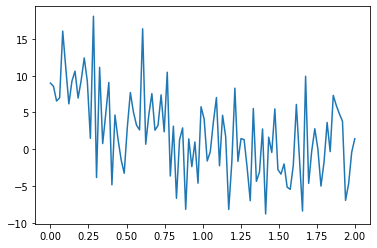

In [2]:
import matplotlib.pyplot as plt 
plt.plot(t, y)
plt.show()

## Grid Search

Let us assume that we we do not know $a$ and $b$ in the exponential model above. 

$$ y = ae^{-bx} + \epsilon \approx f(a,b) $$
 
We can define the likelihood function as the output $y$ given the function is parameterised with $a$ and $b$: 

$$ \mathcal{L} = p(y \mid a, b) = \mathcal{N}(y \mid f(a,b), \sigma^{2}) $$ 

To obtain a posterior distribution, we need to also define a prior on $a$ and $b$: 

$$ p(a,b) = \mathcal{N}(a \mid a_{0}, \sigma_{a,0}^{2}) \cdot \mathcal{N}(b \mid b_{0}, \sigma_{b,0}^{2}) $$

This gives as a posterior distribution: 

\begin{align}
 p(a,b \mid y) &\approx p(y \mid a, b) \cdot p(a, b)  \\
 \\
&\approx  exp\bigg(-\frac{1}{2} \cdot \frac{(y - f(a,b))^{2}}{\sigma^{2}}\bigg)   \cdot p(a,b)  
\end{align}

To obtain the posterior using the grid method, we evalute pairs of $a$ and $b$ on a grid. We can then find the maximum value on the grid corresponding to the values of parameters $a$ and $b$. 




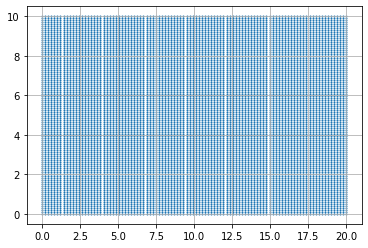

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 

a = np.linspace(0,20,100)
b = np.linspace(0,10,100)

a_n, b_n = np.meshgrid(a, b)

plt.scatter(a_n,b_n, s= 1)
plt.grid(True)
plt.show()

The above figure shows the grid points where the posterior will be approximated. 

`a_n` is a (50,50) array with fixed intervals along the x dimension. 

`b_n` is a (50,50) array with fixed intervalsa along the y dimension.

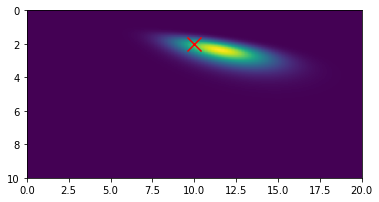

In [4]:
# define a lambda function to evaluate our function with parameters a and b without noise 
f = lambda a, b: a * np.exp(-b*t)

# define another lamnda function to evalute the normal probability density function  at given values of a and b
pdf = lambda a, b: np.exp(-(0.5/sigma**2) * np.sum((y - f(a,b).T)**2))

# set up a 2 dimensional array to fill values of a and b
likelihood_grid = np.ones([100,100])

# loop through values of a and b to populate the grid above, starting with a and working up the y (b) axis. 
for i, aa in enumerate(a):
    for j, bb in enumerate(b):
        likelihood_grid[i][j] = pdf(aa,bb) 

# normalise to the sum of the values (probability distributions should add to 1)
norm_likelihood_grid = likelihood_grid/np.sum(likelihood_grid)
 
# plot the norm_posterior with as a heatmap with the true values plotted as a large red cross
plt.imshow(norm_likelihood_grid.T, extent = [0,20,10,0])
plt.scatter(true_a,true_b, color='r', marker='x', s=200)
plt.show()

### Altnerative python implementation

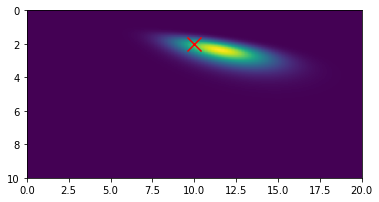

In [5]:
## flatten and reshape arrays to perform matrix algebra
aa = np.tile(a_n.flatten(),(100,1))
bb = b_n.flatten().reshape(10000,1)
tt = t.reshape(len(t),1)
yy = np.tile(y, (10000,1))

# calculate grid values of f(a,b) taking advantage of the shapes of aa, bb and tt
f = aa * np.exp(-tt@bb.T)

# calculate likelihood from normal pdf
likelihood = np.exp(-(0.5/sigma**2) * np.sum((yy.T - f)**2,0))

# normalise to the sum of the values (probability distributions should add to 1)
norm_likelihood = likelihood / np.sum(likelihood)

#reshape (since we vectories the grid) and plot
plt.imshow(norm_likelihood.reshape(100,100), extent = [0,20,10,0])
plt.scatter(true_a,true_b, color='r', marker='x', s=200)
plt.show()


 ## Laplace Approximation

The Laplace approximation is a method for approximating the posterior density with a Gaussian density with variance proportional to it's curvature at the maximium likelihood estimate. 

Consider the following familiar posterior form: 

\begin{align}
 p(a,b \mid y) &\approx  exp\bigg(-\frac{1}{2} \cdot \frac{(y - f(a,b))^{2}}{\sigma^{2}}\bigg)   \cdot p(a,b)  \\
 \\
-\log p(a,b \mid y) &\approx \frac{(y - f(a, b))^{2}}{\sigma^2}
\end{align}

The Laplace approximation states that this can be approximated by: 

$$ p(a, b \mid y) \approx \mathcal{N}(y \mid a_{m}, b_{m}, \sigma^{2}\mathbf{H}^-1) $$

Where $a_{m}, b_{m}$ are the values of $a, b$ that correspond to the maximum likelihood. To calculate the Hessian (and thus curvature), we start by stating a function $g(a,b)$ corresponding to the numerator of the rhs second equation. 

$$ g(a, b) = (y - f(\mathbf{a, b}))^{2} $$ 

Next, we calculate partial derivatives of $f(a,b)$ w.r.t parameters $a$ and $b$. 

\begin{align}
f(a,b) &= ae^{-bt} \\
\\
f_{a} &= e^{-bt} \\
\\
f_{aa} &= 0 \\
\\
f_{ab} = f_{ba} &= -te^{-bt} \\
\\
f_{b} &= -tae^{-bt} \\
\\
f_{bb} &= t^{2}ae^{-bt}

\end{align}

Using these, we can compute the Hessian matrix for our function $g(a, b)$: 

\begin{equation}
\mathbf{H}(g) = 
\begin{bmatrix}
g_{aa} & g_{ab} \\ 
g_{ba} & g_{bb}
\end{bmatrix}
\end{equation}

As an example, here is the derivation for the first entry, $g_{aa}$. 

For convenience, we write $g(a, b)$ as: 

\begin{align*}
g &= (f - y)^{2} \\
\end{align*}

We can then apply the chain rule to obtain the first partial derivative $g_{a}$ and the product rule to obtain the second partial derivative $g_{aa}$:
\begin{align*}
g_{a} &= 2(f_{a})(f - y) \\
\\
g_{aa} &= 2(f_{a})^{2} + 2(f - y)(f_{aa}) \\
\end{align*}

In a similar fashion, we obtain $g_{ab}$, $g_{ba}$, $g_{bb}$: 

\begin{align*}
g_{ab} = g_{ba} &= 2f_{a}f_{b} + 2(f - y)(f_{ab})\\
\\
g_{bb} &= 2(f_{b})^{2} + 2(f - y)(f_{bb})\\

\end{align*}
 
 We can now construct the Hessian matrix and populate our posterior estiamte: 

 $$ p(a, b \mid y) \approx \mathcal{N}(y \mid a_{m}, b_{m}, \sigma^{2}\mathbf{H}^-1) $$ 


 Now, we will look at a python implementation: 

In [6]:
a_m = 10
b_m = 2

# derivatives of f(a,b) = a.exp(-bt)
f = a_m * np.exp(-b_m * t)

f_a = np.exp(-b_m * t)

f_aa = 0 

f_b = -t * a_m * np.exp(-b_m * t)

f_bb = t**2 * a_m * np.exp(-b_m * t)

f_ab = -t * np.exp(-b_m * t)

# derivativs of g(a,b) = (y - f(a,b))^2
g_aa = np.sum(2 * f_a**2 + 2 * (f - y) * (f_aa))

g_ab = np.sum(2 * (f_a * f_b) + 2 * (f - y) * (f_ab))

g_bb = np.sum(2 * f_b**2 + 2 * (f - y) * (f_bb))

# Hessian and inverse
H = np.array([[g_aa,g_ab],[g_ab,g_bb]])
#Hinv = np.linalg.inv(H)

# Covariance
Sigma = np.linalg.inv(H/2/sigma**2)


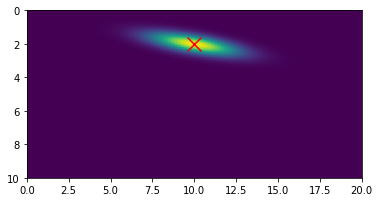

In [7]:
from scipy.stats import multivariate_normal

# Set multivariate normal distribution with max values for a and b and Sigma defined above. 

mv = multivariate_normal(mean=[a_m,b_m],cov=Sigma)

# convert to grid and plot
laplace_a, laplace_b = np.meshgrid(a, b)
pos = np.dstack((laplace_a, laplace_b))
plt.imshow(mv.pdf(pos), extent = [0,20,10,0])
plt.scatter(true_a,true_b, color='r', marker='x', s=200)
plt.show()